In [152]:
# Dependencias tensorflow
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

from tensorflow.keras.models import Model
# Dependencia para trabajar con archivos ZIP
import zipfile
from tensorflow.keras import activations

# Otras liberías
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import pandas as pd
import seaborn as sns
from PIL import Image
import cv2
import glob
import albumentations as A
from ImageDataAugmentor import ImageDataAugmentor
from keras.models import load_model

In [141]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
def get_model():
  input = layers.Input(shape=IMG_SHAPE)
  preprocessing = layers.experimental.preprocessing.Rescaling(1./255)(input)
  x = layers.Conv2D(16, 3, padding='same', activation= activations.relu)(preprocessing)
  x = layers.MaxPooling2D()(x)
  x = layers.Conv2D(32, 3, padding='same', activation= activations.relu)(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Conv2D(64, 3, padding='same', activation= activations.relu)(x)
  x = layers.MaxPooling2D()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  
  output = layers.Dense(1, 'sigmoid')(x)

  model = Model(inputs=[input], outputs=[output])

  return model

In [143]:
ruta = Path('frontal_lateral')

train_f = ruta / 'train/'

test_f = ruta / 'test/'

val_f = ruta / 'validation/'

BATCH_SIZE = 32
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)

In [144]:
# Implementación rutina de transformaciones
transforms = A.Compose([
                        A.Rotate(limit=40, p=0.5),
                        A.RandomBrightnessContrast(p=0.5),
                        A.HorizontalFlip(p=0.5)
                        ])

In [145]:
# Generador de datos de entrenamiento
train_datagen = ImageDataAugmentor(
    augment=transforms)

# Generador de datos de validación sin aumento de datos
val_datagen = ImageDataAugmentor()


In [146]:
# Dataset de entrenamiento
train_dataset = train_datagen.flow_from_directory(
        train_f,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True)

# Dataset validación
validation_dataset = val_datagen.flow_from_directory(
        val_f,
        class_mode='binary',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE)

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


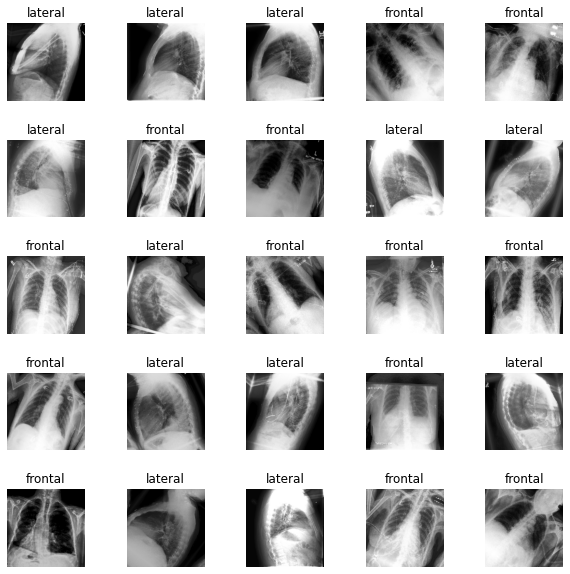

In [147]:
train_dataset.show_data()

In [148]:
model_data_aug = get_model()

model_data_aug.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_10 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                     

In [149]:
path_models = ruta / 'lung' / 'model'
path_experiment = path_models / 'Train'

path_experiment.mkdir(exist_ok=True, parents=True)

In [150]:
# Carpeta donde se guardan los resultados del entrenamiento
path_models = ruta / 'lung_clasification' / 'models'
path_experiment = path_models / 'Train01'

path_experiment.mkdir(exist_ok=True, parents=True)

# Inicia callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_experiment / 'lung_data_aug.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

model_data_aug.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])


history_data_aug = model_data_aug.fit(train_dataset,
                                     epochs=10,
                                     steps_per_epoch= int(600/BATCH_SIZE),
                                     validation_data=validation_dataset,
                                     validation_steps = int(200/BATCH_SIZE),
                                     callbacks=[model_checkpoint_callback],
                                     verbose=1)

np.save(path_experiment / 'history_aug.npy', history_data_aug.history)

Epoch 1/10
18/18 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.7378
Epoch 1: val_accuracy improved from -inf to 0.93229, saving model to frontal_lateral\lung_clasification\models\Train01\lung_data_aug.h5
18/18 [==============================] - 15s 778ms/step - loss: 0.5879 - accuracy: 0.7378 - val_loss: 0.1835 - val_accuracy: 0.9323
Epoch 2/10
18/18 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.9577
Epoch 2: val_accuracy improved from 0.93229 to 0.97396, saving model to frontal_lateral\lung_clasification\models\Train01\lung_data_aug.h5
18/18 [==============================] - 14s 772ms/step - loss: 0.1244 - accuracy: 0.9577 - val_loss: 0.0811 - val_accuracy: 0.9740
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.1187 - accuracy: 0.9525
Epoch 3: val_accuracy improved from 0.97396 to 0.98958, saving model to frontal_lateral\lung_clasification\models\Train01\lung_data_aug.h5
18/18 [==============================] -

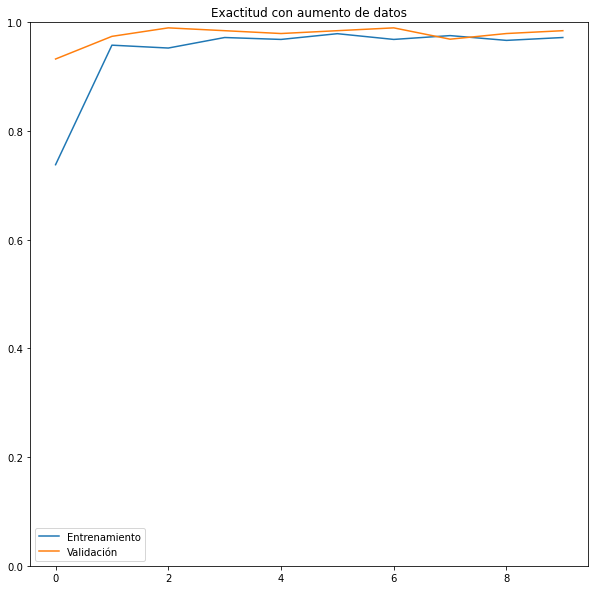

In [151]:
# Visualización curvas de aprendizaje
plt.figure(figsize=(10, 10))
plt.plot(history_data_aug.history['accuracy'], label='Entrenamiento')
plt.plot(history_data_aug.history['val_accuracy'], label='Validación')
plt.title('Exactitud con aumento de datos')
plt.ylim([0,1])
plt.legend()


In [153]:
model = load_model('frontal_lateral/lung_clasification/models/Train01/lung_data_aug.h5')

In [154]:
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_10 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                     